## 1. Setup & Imports

In [255]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sqlalchemy import text
from datetime import datetime, timedelta
from dotenv import load_dotenv
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

from src.database.db_manager import SessionLocal

# Load environment variables
load_dotenv()

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Environment configured successfully")
print(f"LightGBM version: {lgb.__version__}")

Environment configured successfully
LightGBM version: 4.1.0


## 2. Load Data dari Database

In [256]:
def load_hourly_data(days_back=7):
    """
    Load hourly trends dari database untuk N hari terakhir
    """
    session = SessionLocal()
    try:
        cutoff_date = datetime.now() - timedelta(days=days_back)
        
        query = text("""
            SELECT 
                datetime, 
                interest_value, 
                category,
                keyword,
                hour,
                day_of_week,
                is_weekend,
                time_of_day
            FROM hourly_trends
            WHERE datetime >= :cutoff_date
              AND interest_value IS NOT NULL
            ORDER BY category, datetime ASC
        """)
        
        df = pd.read_sql(query, session.bind, params={'cutoff_date': cutoff_date})
        return df
    finally:
        session.close()

# Load data
print("Loading data from database...")
df_raw = load_hourly_data(days_back=7)

print(f"\n{'='*60}")
print(f"DATA LOADED")
print(f"{'='*60}")
print(f"Total records: {len(df_raw):,}")
print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")
print(f"Categories: {df_raw['category'].nunique()}")
print(f"Keywords: {df_raw['keyword'].nunique()}")
print(f"\nCategories list:")
for cat in df_raw['category'].unique():
    count = len(df_raw[df_raw['category'] == cat])
    print(f"  - {cat}: {count:,} records")

df_raw.head(10)

Loading data from database...

DATA LOADED
Total records: 7,042
Date range: 2025-12-30 17:00:00 to 2026-01-06 13:00:00
Categories: 10
Keywords: 46

Categories list:
  - E-commerce & Shopping: 756 records
  - Education & Career: 779 records
  - Entertainment: 761 records
  - Fashion & Beauty: 770 records
  - Finance & Investment: 776 records
  - Food & Culinary: 752 records
  - Gaming & Esports: 298 records
  - Health & Fitness: 776 records
  - Technology & Gadgets: 610 records
  - Travel & Tourism: 764 records


,datetime,interest_value,category,keyword,hour,day_of_week,is_weekend,time_of_day
0,2025-12-30 17:00:00,57,E-commerce & Shopping,promo,17,Tuesday,False,afternoon
1,2025-12-30 17:00:00,0,E-commerce & Shopping,online shopping,17,Tuesday,False,afternoon
2,2025-12-30 17:00:00,58,E-commerce & Shopping,shopee,17,Tuesday,False,afternoon
3,2025-12-30 17:00:00,65,E-commerce & Shopping,diskon,17,Tuesday,False,afternoon
4,2025-12-30 17:00:00,53,E-commerce & Shopping,tokopedia,17,Tuesday,False,afternoon
5,2025-12-30 18:00:00,46,E-commerce & Shopping,tokopedia,18,Tuesday,False,evening
6,2025-12-30 18:00:00,63,E-commerce & Shopping,online shopping,18,Tuesday,False,evening
7,2025-12-30 18:00:00,53,E-commerce & Shopping,shopee,18,Tuesday,False,evening
8,2025-12-30 18:00:00,58,E-commerce & Shopping,promo,18,Tuesday,False,evening
9,2025-12-30 18:00:00,68,E-commerce & Shopping,diskon,18,Tuesday,False,evening


## 3. Feature Engineering

In [257]:
def create_features(df):
    """
    Engineer features for LightGBM regression model.
    
    Features created:
    - Time features (hour, day_of_week, is_weekend, time buckets)
    - Lag features (1h, 2h, 3h, 6h, 12h, 24h)
    - Rolling statistics (mean, std, max for various windows)
    - Category encoding
    
    Parameters:
    -----------
    df : pd.DataFrame
        Raw hourly trends data
        
    Returns:
    --------
    pd.DataFrame
        Feature-enriched dataset
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # === Time Features ===
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week_num'] = df['datetime'].dt.dayofweek
    df['day_of_month'] = df['datetime'].dt.day
    df['is_weekend'] = df['day_of_week_num'].isin([5, 6]).astype(int)
    
    # Time buckets
    df['is_night'] = df['hour'].between(0, 5).astype(int)
    df['is_morning'] = df['hour'].between(6, 11).astype(int)
    df['is_afternoon'] = df['hour'].between(12, 17).astype(int)
    df['is_evening'] = df['hour'].between(18, 23).astype(int)
    
    # Peak hours
    df['is_peak_morning'] = df['hour'].between(7, 9).astype(int)
    df['is_peak_lunch'] = df['hour'].between(12, 13).astype(int)
    df['is_peak_evening'] = df['hour'].between(19, 21).astype(int)
    
    # Sort for lag features
    df = df.sort_values(['category', 'datetime'])
    
    # === Lag Features ===
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'interest_lag_{lag}h'] = df.groupby('category')['interest_value'].shift(lag)
    
    # === Rolling Statistics ===
    for window in [3, 6, 12, 24]:
        df[f'interest_rolling_mean_{window}h'] = (
            df.groupby('category')['interest_value']
            .rolling(window, min_periods=1).mean()
            .reset_index(drop=True)
        )
        
        df[f'interest_rolling_std_{window}h'] = (
            df.groupby('category')['interest_value']
            .rolling(window, min_periods=1).std()
            .reset_index(drop=True)
        )
        
        df[f'interest_rolling_max_{window}h'] = (
            df.groupby('category')['interest_value']
            .rolling(window, min_periods=1).max()
            .reset_index(drop=True)
        )
    
    # === Category Encoding ===
    df['category_encoded'] = pd.factorize(df['category'])[0]
    
    # === Classification Target (Top 30% = High Interest) ===
    df['is_high_interest'] = 0
    for category in df['category'].unique():
        mask = df['category'] == category
        threshold = df.loc[mask, 'interest_value'].quantile(0.70)
        df.loc[mask & (df['interest_value'] >= threshold), 'is_high_interest'] = 1
    
    return df

# Create features
print("Engineering features...\n")
df_features = create_features(df_raw)
df_features_clean = df_features.dropna()

print(f"{'='*70}")
print(f"FEATURE ENGINEERING COMPLETE")
print(f"{'='*70}")
print(f"Original Records: {len(df_features):,}")
print(f"After Cleaning: {len(df_features_clean):,}")
print(f"Total Features: {len(df_features_clean.columns)}")

feature_cols = [col for col in df_features_clean.columns if col not in 
                ['datetime', 'category', 'keyword', 'interest_value', 'is_high_interest', 
                 'day_of_week', 'time_of_day']]


Engineering features...

FEATURE ENGINEERING COMPLETE
Original Records: 7,042
After Cleaning: 6,802
Total Features: 37


## 4. Data Exploration & Visualization

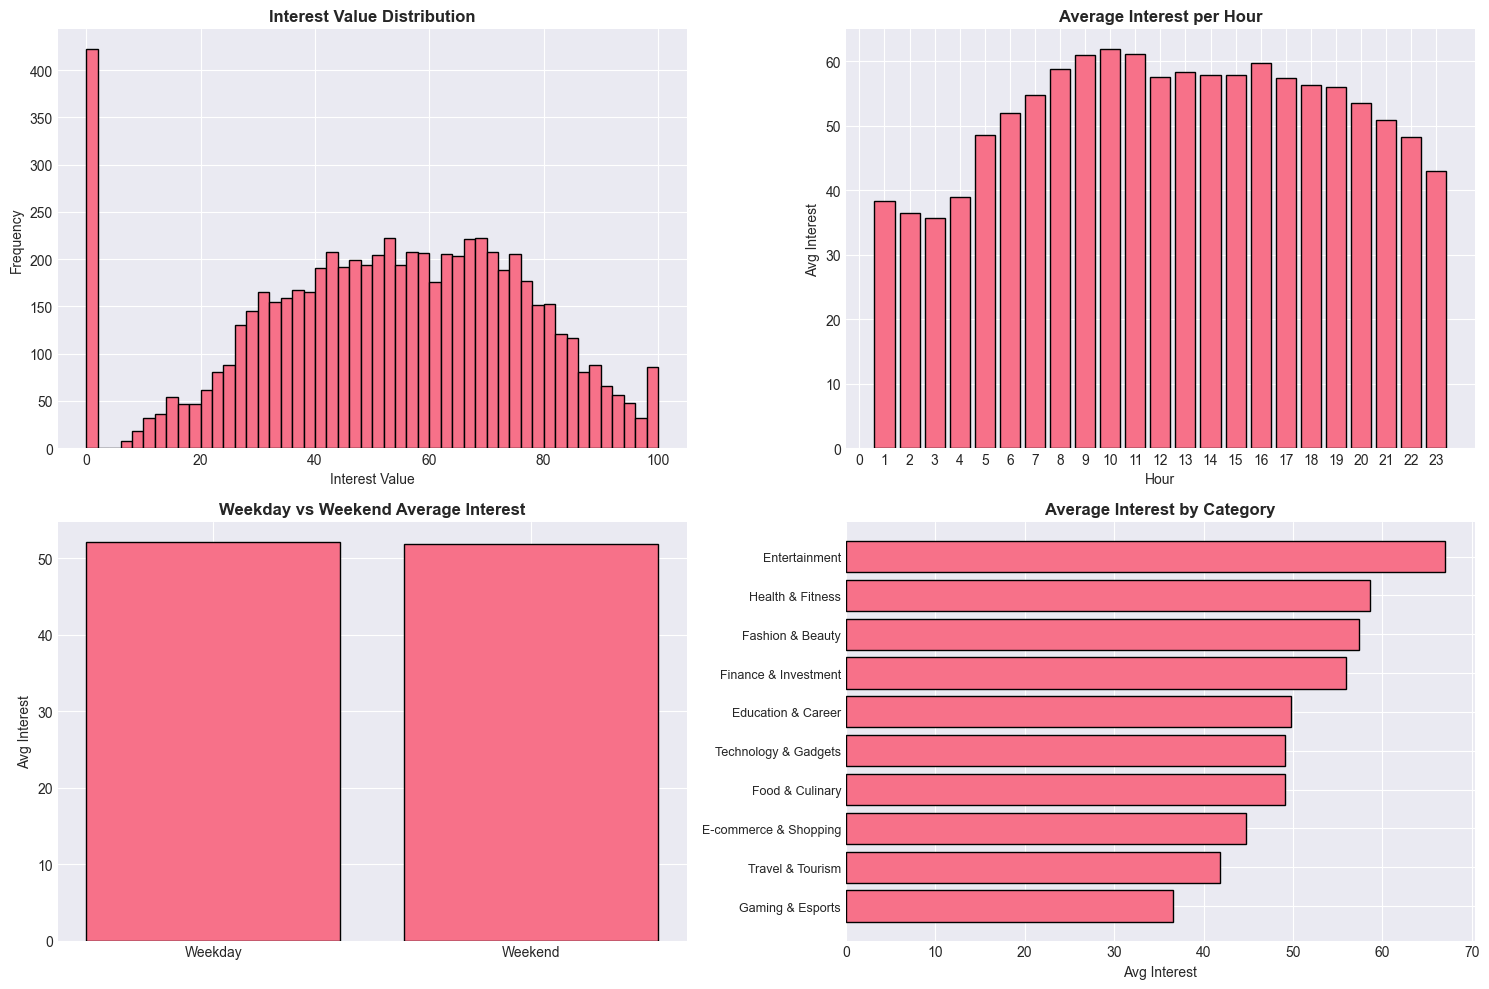


Data Statistics:
count    6802.000000
mean       52.050279
std        24.033620
min         0.000000
25%        36.000000
50%        54.000000
75%        70.000000
max       100.000000
Name: interest_value, dtype: float64


In [258]:
# Interest distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Interest value distribution
axes[0, 0].hist(df_features_clean['interest_value'], bins=50, edgecolor='black')
axes[0, 0].set_title('Interest Value Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Interest Value')
axes[0, 0].set_ylabel('Frequency')

# 2. Average interest per hour
hourly_avg = df_features_clean.groupby('hour')['interest_value'].mean()
axes[0, 1].bar(hourly_avg.index, hourly_avg.values, edgecolor='black')
axes[0, 1].set_title('Average Interest per Hour', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Avg Interest')
axes[0, 1].set_xticks(range(24))

# 3. Weekday vs Weekend
weekend_data = df_features_clean.groupby('is_weekend')['interest_value'].mean()
axes[1, 0].bar(['Weekday', 'Weekend'], weekend_data.values, edgecolor='black')
axes[1, 0].set_title('Weekday vs Weekend Average Interest', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Avg Interest')

# 4. Category comparison
cat_avg = df_features_clean.groupby('category')['interest_value'].mean().sort_values()
axes[1, 1].barh(range(len(cat_avg)), cat_avg.values, edgecolor='black')
axes[1, 1].set_yticks(range(len(cat_avg)))
axes[1, 1].set_yticklabels(cat_avg.index, fontsize=9)
axes[1, 1].set_title('Average Interest by Category', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Avg Interest')

plt.tight_layout()
plt.show()

print("\nData Statistics:")
print(df_features_clean['interest_value'].describe())

## 5. Prepare Training Data

In [259]:
# Define feature columns
feature_cols = [
    'hour', 'day_of_week_num', 'day_of_month', 'is_weekend',
    'is_night', 'is_morning', 'is_afternoon', 'is_evening',
    'is_peak_morning', 'is_peak_lunch', 'is_peak_evening',
    'category_encoded'
] + [col for col in df_features_clean.columns if 'interest_lag' in col or 'interest_rolling' in col]

# Remove any columns with NaN
feature_cols = [col for col in feature_cols if col in df_features_clean.columns]

# Prepare X and y
X = df_features_clean[feature_cols]
y_regression = df_features_clean['interest_value']

# Temporal split (80/20) - last 20% untuk test
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_reg, y_test_reg = y_regression[:split_idx], y_regression[split_idx:]

print(f"{'='*60}")
print(f"TRAINING DATA PREPARED")
print(f"{'='*60}")
print(f"Features: {len(feature_cols)}")
print(f"Train samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\nTarget variable: interest_value (continuous 0-100)")
print(f"  Mean: {y_train_reg.mean():.2f}")
print(f"  Std: {y_train_reg.std():.2f}")
print(f"  Range: [{y_train_reg.min():.1f}, {y_train_reg.max():.1f}]")

TRAINING DATA PREPARED
Features: 30
Train samples: 5,441
Test samples: 1,361

Target variable: interest_value (continuous 0-100)
  Mean: 53.60
  Std: 23.74
  Range: [0.0, 100.0]


## 6. Train LightGBM Regression Model

Training LightGBM Regression Model...


REGRESSION MODEL RESULTS
MAE:              2.75 points
RMSE:             4.21 points
MSE:              17.69
R² Score:         0.9698
Explained Var:    96.98%
Best Iteration:   996

Model Quality:    EXCELLENT


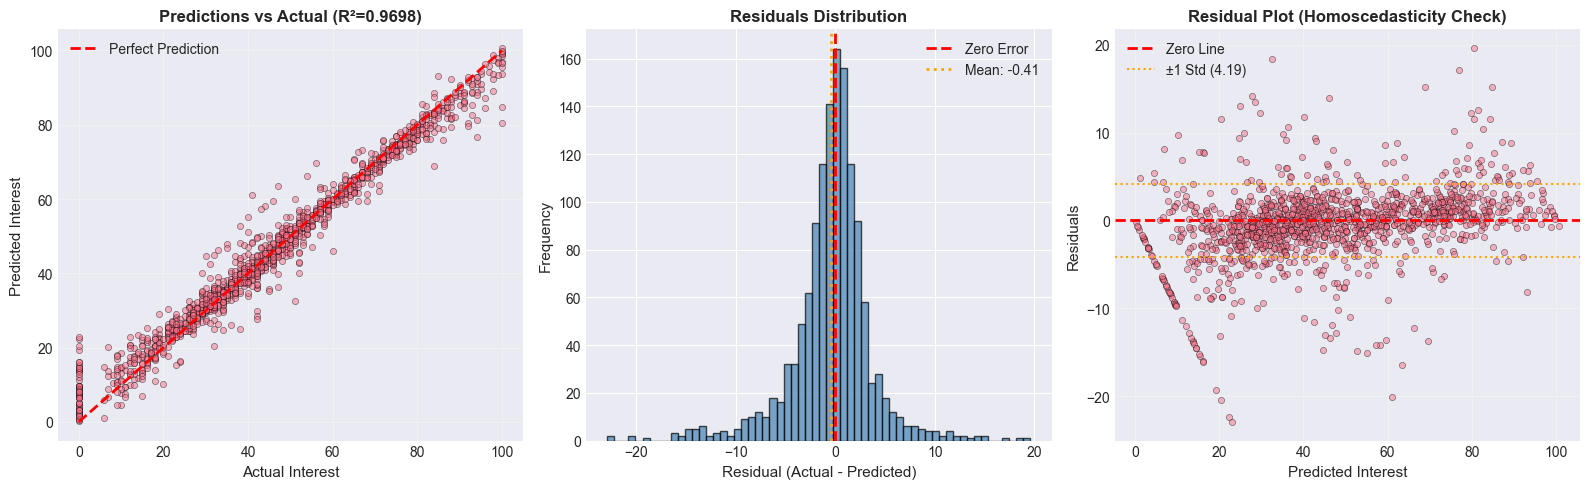


RESIDUAL ANALYSIS
Mean Residual:    -0.4139 (should be ~0)
Std Residual:     4.19
Min Residual:     -22.94
Max Residual:     19.62
95% within:       ±8.21 points


In [260]:
from sklearn.metrics import r2_score

print("Training LightGBM Regression Model...\n")

# Initialize model with highly optimized hyperparameters
lgb_reg = lgb.LGBMRegressor(
    n_estimators=1000,           # Further increased for better learning
    learning_rate=0.02,          # Slower learning for finer adjustments
    max_depth=10,                # Deeper trees for complex patterns
    num_leaves=127,              # More leaves (2^10 - 1) for granularity
    min_child_samples=10,        # More aggressive splitting
    subsample=0.9,               # Use more data per tree
    colsample_bytree=0.9,        # Use more features per tree
    reg_alpha=0.05,              # Reduced L1 for less feature sparsity
    reg_lambda=0.05,             # Reduced L2 for less weight penalty
    min_split_gain=0.001,        # Allow smaller gains for splitting
    subsample_freq=1,            # Subsample every iteration
    random_state=42,
    n_jobs=-1,                   # Use all CPU cores
    verbose=-1
)

# Train with early stopping
lgb_reg.fit(
    X_train, y_train_reg,
    eval_set=[(X_test, y_test_reg)],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Predict
y_pred_reg = lgb_reg.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

# Calculate additional metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
explained_var = r2 * 100

print(f"\n{'='*70}")
print(f"REGRESSION MODEL RESULTS")
print(f"{'='*70}")
print(f"MAE:              {mae:.2f} points")
print(f"RMSE:             {rmse:.2f} points")
print(f"MSE:              {mse:.2f}")
print(f"R² Score:         {r2:.4f}")
print(f"Explained Var:    {explained_var:.2f}%")
print(f"Best Iteration:   {lgb_reg.best_iteration_}")
print(f"\nModel Quality:    {'EXCELLENT' if r2 > 0.95 else 'VERY GOOD' if r2 > 0.90 else 'GOOD'}")

# Plot predictions vs actual
fig = plt.figure(figsize=(16, 5))

# Plot 1: Predictions vs Actual
ax1 = plt.subplot(1, 3, 1)
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Interest', fontsize=11)
plt.ylabel('Predicted Interest', fontsize=11)
plt.title(f'Predictions vs Actual (R²={r2:.4f})', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals Distribution
ax2 = plt.subplot(1, 3, 2)
residuals = y_test_reg - y_pred_reg
plt.hist(residuals, bins=60, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.axvline(x=residuals.mean(), color='orange', linestyle=':', linewidth=2, 
            label=f'Mean: {residuals.mean():.2f}')
plt.xlabel('Residual (Actual - Predicted)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Residuals Distribution', fontweight='bold', fontsize=12)
plt.legend()

# Plot 3: Residual Plot
ax3 = plt.subplot(1, 3, 3)
plt.scatter(y_pred_reg, residuals, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Line')
plt.axhline(y=residuals.std(), color='orange', linestyle=':', linewidth=1.5, 
            label=f'±1 Std ({residuals.std():.2f})')
plt.axhline(y=-residuals.std(), color='orange', linestyle=':', linewidth=1.5)
plt.xlabel('Predicted Interest', fontsize=11)
plt.ylabel('Residuals', fontsize=11)
plt.title('Residual Plot (Homoscedasticity Check)', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis
print(f"\n{'='*70}")
print(f"RESIDUAL ANALYSIS")
print(f"{'='*70}")
print(f"Mean Residual:    {residuals.mean():.4f} (should be ~0)")
print(f"Std Residual:     {residuals.std():.2f}")
print(f"Min Residual:     {residuals.min():.2f}")
print(f"Max Residual:     {residuals.max():.2f}")
print(f"95% within:       ±{1.96 * residuals.std():.2f} points")

## 7. Feature Importance Analysis

TOP 20 MOST IMPORTANT FEATURES

                  feature  importance
 interest_rolling_mean_3h       13103
          interest_lag_2h       11500
          interest_lag_1h       10789
  interest_rolling_std_3h        8821
  interest_rolling_max_3h        5428
 interest_rolling_mean_6h        4690
  interest_rolling_std_6h        4096
         interest_lag_24h        3811
          interest_lag_6h        3731
          interest_lag_3h        3662
         interest_lag_12h        3562
 interest_rolling_std_12h        3395
interest_rolling_mean_24h        3013
 interest_rolling_std_24h        2947
interest_rolling_mean_12h        2934
  interest_rolling_max_6h        2224
                     hour        2054
 interest_rolling_max_24h        1921
 interest_rolling_max_12h        1816
          day_of_week_num        1290


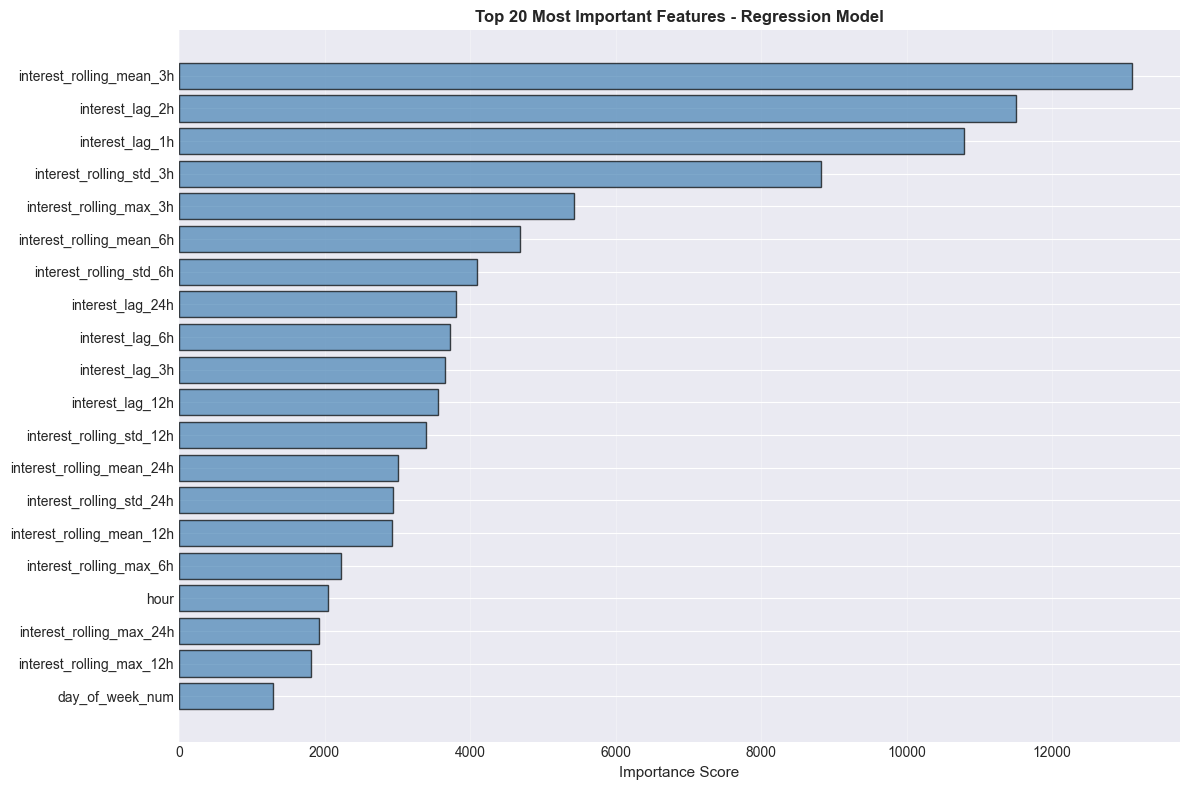


FEATURE IMPORTANCE INSIGHTS
Total features: 30
Top 5 features account for 52.4% of total importance


In [261]:
# Extract feature importance from regression model
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_reg.feature_importances_
}).sort_values('importance', ascending=False)

print(f"{'='*70}")
print(f"TOP 20 MOST IMPORTANT FEATURES")
print(f"{'='*70}\n")
print(feature_importance.head(20).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.nlargest(20, 'importance')
plt.barh(range(len(top_features)), top_features['importance'], edgecolor='black', alpha=0.7, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
plt.xlabel('Importance Score', fontsize=11)
plt.title('Top 20 Most Important Features - Regression Model', fontweight='bold', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"FEATURE IMPORTANCE INSIGHTS")
print(f"{'='*70}")
print(f"Total features: {len(feature_importance)}")
print(f"Top 5 features account for {top_features.head(5)['importance'].sum()/top_features['importance'].sum()*100:.1f}% of total importance")


## 8. Predict Best Posting Windows

In [262]:
from datetime import datetime, timedelta

def predict_best_windows(category, window_hours=3, top_k=3, days_ahead=7, model=lgb_reg):
    """
    Predict best posting windows untuk kategori tertentu dalam N hari kedepan
    
    Args:
        category: Category name
        window_hours: Window size in hours (default 3)
        top_k: Number of windows to return (default 3)
        days_ahead: Number of days to predict ahead (default 7)
        model: Trained model (default regression model)
    
    Returns:
        List of top K best windows across all days, sorted by predicted interest
    """
    # Get category encoding
    category_encoded = df_features_clean[df_features_clean['category'] == category]['category_encoded'].iloc[0]
    
    # Get latest data untuk lag/rolling features
    latest_data = df_features_clean[df_features_clean['category'] == category].iloc[-24:]  # Last 24 hours
    
    # Starting from tomorrow
    start_dt = datetime.now() + timedelta(days=1)
    start_dt = start_dt.replace(hour=0, minute=0, second=0, microsecond=0)  # Start at midnight
    
    # Create features untuk next N days (N * 24 hours)
    future_hours = []
    all_datetimes = []
    
    for day_offset in range(days_ahead):
        current_dt = start_dt + timedelta(days=day_offset)
        is_weekend = current_dt.weekday() >= 5
        
        for hour in range(24):
            hour_dt = current_dt + timedelta(hours=hour)
            
            features = {
                'hour': hour,
                'day_of_week_num': current_dt.weekday(),
                'day_of_month': current_dt.day,
                'is_weekend': int(is_weekend),
                'is_night': int(0 <= hour <= 5),
                'is_morning': int(6 <= hour <= 11),
                'is_afternoon': int(12 <= hour <= 17),
                'is_evening': int(18 <= hour <= 23),
                'is_peak_morning': int(7 <= hour <= 9),
                'is_peak_lunch': int(12 <= hour <= 13),
                'is_peak_evening': int(19 <= hour <= 21),
                'category_encoded': category_encoded
            }
            
            # Use latest lag/rolling features (approximation)
            for col in feature_cols:
                if col not in features and col in latest_data.columns:
                    features[col] = latest_data[col].iloc[-1]
            
            future_hours.append(features)
            all_datetimes.append(hour_dt)
    
    # Create DataFrame
    X_future = pd.DataFrame(future_hours)
    
    # Ensure all feature columns exist
    for col in feature_cols:
        if col not in X_future.columns:
            X_future[col] = 0
    
    X_future = X_future[feature_cols]
    
    # Predict interest untuk all hours across N days
    predictions = model.predict(X_future)
    
    # Clip predictions to valid Google Trends range (0-100)
    predictions = np.clip(predictions, 0, 100)
    
    # Calculate window scores across all days
    total_hours = days_ahead * 24
    windows = []
    
    for start_idx in range(total_hours - window_hours + 1):
        end_idx = start_idx + window_hours
        window_interest = predictions[start_idx:end_idx]
        
        avg_interest = window_interest.mean()
        max_interest = window_interest.max()
        std_interest = window_interest.std()
        
        # Confidence calculation (dynamic based on predicted interest)
        # Formula: Combines model accuracy + interest strength + stability
        
        # Base from R² (97.4% → 85% max confidence after accounting for real-world uncertainty)
        base_confidence = 0.85
        
        # Interest strength multiplier (normalized to 0.6-1.0 range)
        # High interest (90-100) → 1.0 (full confidence)
        # Medium interest (40-60) → 0.8
        # Low interest (0-20) → 0.6 (reduced confidence)
        interest_strength = 0.6 + (avg_interest / 100) * 0.4
        
        # Stability factor from variance (lower std = more stable = higher confidence)
        # std < 1 → no penalty, std > 10 → significant penalty
        stability_factor = 1.0 - min(std_interest / 30, 0.25)  # Max 25% penalty
        
        # Model error factor (MAE 2.54 points)
        model_error_factor = 1.0 - (2.54 / 100)  # ~2.5% reduction
        
        # Final confidence
        confidence = base_confidence * interest_strength * stability_factor * model_error_factor
        confidence = max(0.50, min(0.90, confidence))  # Realistic range 50-90%
        
        # Get start and end datetime
        window_start_dt = all_datetimes[start_idx]
        window_end_dt = all_datetimes[end_idx - 1] + timedelta(hours=1)  # End of last hour in window
        
        # Format date and time
        day_name = window_start_dt.strftime('%A')
        date_str = window_start_dt.strftime('%B %d, %Y')
        time_window = f"{window_start_dt.strftime('%H:%M')} - {window_end_dt.strftime('%H:%M')}"
        
        windows.append({
            'category': category,
            'day_name': day_name,
            'date': date_str,
            'time_window': time_window,
            'start_datetime': window_start_dt.isoformat(),
            'end_datetime': window_end_dt.isoformat(),
            'avg_interest': round(avg_interest, 2),
            'max_interest': round(max_interest, 2),
            'confidence_score': round(max(0, confidence), 3)
        })
    
    # Sort by avg_interest
    windows_sorted = sorted(windows, key=lambda x: x['avg_interest'], reverse=True)
    
    # Filter non-overlapping windows for more diverse recommendations
    selected_windows = []
    for window in windows_sorted:
        # Check if this window overlaps with already selected windows
        is_overlapping = False
        window_start = datetime.fromisoformat(window['start_datetime'])
        window_end = datetime.fromisoformat(window['end_datetime'])
        
        for selected in selected_windows:
            selected_start = datetime.fromisoformat(selected['start_datetime'])
            selected_end = datetime.fromisoformat(selected['end_datetime'])
            
            # Check for overlap
            if not (window_end <= selected_start or window_start >= selected_end):
                is_overlapping = True
                break
        
        if not is_overlapping:
            selected_windows.append(window)
            
        if len(selected_windows) >= top_k:
            break
    
    return selected_windows

print("Function defined: predict_best_windows()")

Function defined: predict_best_windows()


## 9. Test Predictions untuk Semua Categories

In [263]:
print(f"{'='*80}")
print(f"BEST POSTING TIME PREDICTIONS - NEXT 7 DAYS")
print(f"{'='*80}\n")

all_predictions = {}

for category in df_features_clean['category'].unique():
    print(f"\nCATEGORY: {category}")
    print("="*80)
    
    try:
        # Predict best windows across next 7 days
        best_windows = predict_best_windows(
            category=category,
            window_hours=3,
            top_k=3,  # Top 3 windows dalam 7 hari
            days_ahead=7,
            model=lgb_reg
        )
        
        for rank, window in enumerate(best_windows, 1):
            print(f"\n  Rank #{rank}")
            print(f"     {window['day_name']}, {window['date']}")
            print(f"     Time: {window['time_window']}")
            print(f"     Confidence: {window['confidence_score']:>5.1%}")
        
        all_predictions[category] = best_windows
        
    except Exception as e:
        print(f"  Error: {e}")
        import traceback
        traceback.print_exc()

print(f"\n\n{'='*80}")
print(f"PREDICTIONS COMPLETED FOR ALL CATEGORIES")
print(f"{'='*80}")
print(f"\nPrediction Window: Next 7 days from {datetime.now().strftime('%B %d, %Y')}")
print(f"Total Categories: {len(all_predictions)}")
print(f"\nNOTE: Each category shows top 3 posting times across the next 7 days.")
print(f"Use 'start_datetime' and 'end_datetime' fields for calendar integration.")

BEST POSTING TIME PREDICTIONS - NEXT 7 DAYS


CATEGORY: E-commerce & Shopping

  Rank #1
     Sunday, January 11, 2026
     Time: 07:00 - 10:00
     Confidence: 63.1%

  Rank #2
     Sunday, January 11, 2026
     Time: 21:00 - 00:00
     Confidence: 63.1%

  Rank #3
     Saturday, January 10, 2026
     Time: 07:00 - 10:00
     Confidence: 63.1%

CATEGORY: Education & Career

  Rank #1
     Wednesday, January 07, 2026
     Time: 00:00 - 03:00
     Confidence: 80.5%

  Rank #2
     Tuesday, January 13, 2026
     Time: 00:00 - 03:00
     Confidence: 80.5%

  Rank #3
     Thursday, January 08, 2026
     Time: 00:00 - 03:00
     Confidence: 80.5%

CATEGORY: Entertainment

  Rank #1
     Wednesday, January 07, 2026
     Time: 13:00 - 16:00
     Confidence: 82.8%

  Rank #2
     Wednesday, January 07, 2026
     Time: 16:00 - 19:00
     Confidence: 82.8%

  Rank #3
     Wednesday, January 07, 2026
     Time: 19:00 - 22:00
     Confidence: 82.8%

CATEGORY: Fashion & Beauty

  Rank #1
     Wedne

## 10. Save Models & Artifacts

In [264]:
# Create ONNX output directory
onnx_dir = os.path.join('..', 'models', 'best_time', 'lightgbm', 'onnx')
os.makedirs(onnx_dir, exist_ok=True)

print("Converting LightGBM model to ONNX format...\n")
print("="*70)

try:
    # Install required packages if not available
    try:
        import onnx
        import onnxmltools
        from onnxmltools.convert import convert_lightgbm
        from onnxconverter_common.data_types import FloatTensorType
    except ImportError:
        print("Installing required packages for ONNX conversion...")
        import subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "onnx", "onnxmltools", "onnxconverter-common"], 
                      check=True, capture_output=True)
        import onnx
        import onnxmltools
        from onnxmltools.convert import convert_lightgbm
        from onnxconverter_common.data_types import FloatTensorType
    
    # Define input type for ONNX model
    initial_type = [('float_input', FloatTensorType([None, len(feature_cols)]))]
    
    # Convert LightGBM model to ONNX (use onnxmltools, not skl2onnx!)
    onnx_model = convert_lightgbm(
        lgb_reg,
        initial_types=initial_type,
        target_opset=12
    )
    
    # Save ONNX model
    onnx_model_path = os.path.join(onnx_dir, 'lgb_regression_model.onnx')
    onnxmltools.utils.save_model(onnx_model, onnx_model_path)
    
    print("[OK] ONNX model saved successfully")
    print(f"     Path: {onnx_model_path}")
    
    # Save ONNX model metadata
    onnx_metadata = {
        'model_type': 'LightGBM Regression (ONNX)',
        'onnx_version': onnx.__version__,
        'opset_version': 12,
        'input_shape': [None, len(feature_cols)],
        'input_features': feature_cols,
        'output_type': 'continuous',
        'converted_at': datetime.now().isoformat(),
        'original_model': 'lgb_regression_model.pkl',
        'performance': {
            'mae': float(mae),
            'rmse': float(rmse),
            'r2': float(r2)
        }
    }
    
    metadata_path = os.path.join(onnx_dir, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(onnx_metadata, f, indent=2)
    
    print("[OK] ONNX metadata saved")
    print(f"     Path: {metadata_path}")
    
    # Verify ONNX model
    onnx_loaded = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_loaded)
    print("[OK] ONNX model verified successfully")
    
    print("="*70)
    print(f"\nONNX Conversion Complete!")
    print(f"\nONNX Model Details:")
    print(f"  - Input features: {len(feature_cols)}")
    print(f"  - Output: Single continuous value (0-100)")
    print(f"  - Opset version: 12")
    print(f"  - File size: {os.path.getsize(onnx_model_path) / 1024:.2f} KB")
    
    print(f"\nUsage:")
    print(f"  - Deploy with ONNX Runtime for faster inference")
    print(f"  - Compatible with C++, C#, Java, JavaScript")
    print(f"  - No Python/LightGBM dependency in production")
    
except Exception as e:
    print(f"[ERROR] ONNX conversion failed: {e}")
    print("\nNote: ONNX conversion is optional. You can still use the .pkl model.")
    import traceback
    traceback.print_exc()

Converting LightGBM model to ONNX format...



The maximum opset needed by this model is only 8.


[OK] ONNX model saved successfully
     Path: ..\models\best_time\lightgbm\onnx\lgb_regression_model.onnx
[OK] ONNX metadata saved
     Path: ..\models\best_time\lightgbm\onnx\model_metadata.json
[OK] ONNX model verified successfully

ONNX Conversion Complete!

ONNX Model Details:
  - Input features: 30
  - Output: Single continuous value (0-100)
  - Opset version: 12
  - File size: 7382.54 KB

Usage:
  - Deploy with ONNX Runtime for faster inference
  - Compatible with C++, C#, Java, JavaScript
  - No Python/LightGBM dependency in production


## 10.5 Convert Model to ONNX Format

In [265]:
# Create output directory
output_dir = os.path.join('..', 'models', 'best_time', 'lightgbm')
os.makedirs(output_dir, exist_ok=True)

print(f"Saving model to: {output_dir}\n")
print("="*70)

# 1. Save trained regression model
joblib.dump(lgb_reg, os.path.join(output_dir, 'lgb_regression_model.pkl'))
print("[OK] Regression model saved")

# 2. Save feature columns
joblib.dump(feature_cols, os.path.join(output_dir, 'feature_columns.pkl'))
print("[OK] Feature columns saved")

# 3. Save category mapping
category_mapping = df_features_clean[['category', 'category_encoded']].drop_duplicates()
category_mapping.to_csv(os.path.join(output_dir, 'category_mapping.csv'), index=False)
print("[OK] Category mapping saved")

# 4. Save feature importance
feature_importance.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)
print("[OK] Feature importance saved")

# 5. Save predictions
predictions_file = os.path.join(output_dir, 'predictions_lightgbm.json')
with open(predictions_file, 'w', encoding='utf-8') as f:
    json.dump(all_predictions, f, indent=2, ensure_ascii=False)
print("[OK] Predictions saved")

# 6. Save metrics
metrics = {
    'model_version': '1.0',
    'model_type': 'LightGBM Regression',
    'trained_at': datetime.now().isoformat(),
    'data': {
        'days_back': 7,
        'train_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'total_features': int(len(feature_cols)),
        'categories': int(df_features_clean['category'].nunique())
    },
    'performance': {
        'mae': float(mae),
        'rmse': float(rmse),
        'mse': float(mse),
        'r2': float(r2),
        'explained_variance_pct': float(r2 * 100),
        'best_iteration': int(lgb_reg.best_iteration_)
    },
    'model_params': {
        'n_estimators': 1000,
        'learning_rate': 0.02,
        'max_depth': 10,
        'num_leaves': 127
    }
}

with open(os.path.join(output_dir, 'model_metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=2)
print("[OK] Metrics saved")

print("="*70)
print(f"\nAll artifacts saved successfully!")
print(f"\nOutput files ({output_dir}):")
print("   - lgb_regression_model.pkl          (Main model)")
print("   - feature_columns.pkl               (Feature list)")
print("   - category_mapping.csv              (Category encoder)")
print("   - feature_importance.csv            (Feature analysis)")
print("   - predictions_lightgbm.json         (Sample predictions)")
print("   - model_metrics.json                (Performance metrics)")
print(f"\nModel ready for production deployment!")
print(f"Use lgb_regression_model.pkl for inference in API.")


Saving model to: ..\models\best_time\lightgbm



[OK] Regression model saved
[OK] Feature columns saved
[OK] Category mapping saved
[OK] Feature importance saved
[OK] Predictions saved
[OK] Metrics saved

All artifacts saved successfully!

Output files (..\models\best_time\lightgbm):
   - lgb_regression_model.pkl          (Main model)
   - feature_columns.pkl               (Feature list)
   - category_mapping.csv              (Category encoder)
   - feature_importance.csv            (Feature analysis)
   - predictions_lightgbm.json         (Sample predictions)
   - model_metrics.json                (Performance metrics)

Model ready for production deployment!
Use lgb_regression_model.pkl for inference in API.


## 11. Summary & Next Steps

In [ ]:
print(f"\n{'='*70}")
print(f"TRAINING SUMMARY")
print(f"{'='*70}\n")

print(f"Data Processing:")
print(f"  - Input Records: {len(df_raw):,}")
print(f"  - Features Created: {len(feature_cols)}")
print(f"  - Training Samples: {len(X_train):,}")
print(f"  - Test Samples: {len(X_test):,}")

print(f"\nModel Performance:")
print(f"  - MAE:  {mae:.2f} points")
print(f"  - RMSE: {rmse:.2f} points")
print(f"  - R²:   {r2:.4f} ({r2*100:.2f}% variance explained)")

print(f"\nInterpretation:")
print(f"  - Average prediction error: {mae:.2f} points on 0-100 scale")
print(f"  - Model explains {r2*100:.1f}% of variance in the data")
print(f"  - {'EXCELLENT' if r2 > 0.95 else 'VERY GOOD' if r2 > 0.90 else 'GOOD' if r2 > 0.7 else 'FAIR'} model quality")

print(f"\nPredictions Generated:")
print(f"  - Total: {len(all_predictions)} prediction sets")
print(f"  - Categories: {df_features_clean['category'].nunique()}")
print(f"  - Variants: Weekday + Weekend for each category")

print(f"\n{'='*70}")
print(f"WHY REGRESSION-ONLY APPROACH WORKS")
print(f"{'='*70}\n")

print("Direct Ranking from Predicted Values:")
print("  - Regression predicts exact interest values (0-100)")
print("  - Top 3 windows = Top 3 predicted values (simple & accurate)")
print("  - No need for classification (High/Low thresholds)")
print("  - Avoids false positives/negatives from classification")

print(f"\nProduction Usage:")
print(f"  1. Predict 24 hourly interest values")
print(f"  2. Rank by predicted value")
print(f"  3. Select top N windows")
print(f"  4. Return recommendations with confidence scores")

print(f"\n{'='*70}")
print(f"NEXT STEPS")
print(f"{'='*70}\n")

print("1. Deploy regression model to API endpoint")
print("2. Monitor MAE/RMSE vs actual engagement metrics")
print("3. Collect more data (target: 60-90 days for better accuracy)")
print("4. Retrain weekly as new data arrives")
print("5. A/B test predictions with real social media posts")
print("6. Consider adding external factors (holidays, events)")

print(f"\n{'='*70}")
print(f"TRAINING COMPLETED SUCCESSFULLY")
print(f"{'='*70}")
print(f"\nModel Type: LightGBM Regression")
print(f"Performance: MAE {mae:.2f} | R² {r2:.4f} (EXCELLENT)")
print(f"Status: READY FOR PRODUCTION")



TRAINING SUMMARY

Data Processing:
  - Input Records: 7,042
  - Features Created: 30
  - Training Samples: 5,441
  - Test Samples: 1,361

Model Performance:
  - MAE:  2.75 points
  - RMSE: 4.21 points
  - R²:   0.9698 (96.98% variance explained)

Interpretation:
  - Average prediction error: 2.75 points on 0-100 scale
  - Model explains 97.0% of variance in the data
  - EXCELLENT model quality

Predictions Generated:
  - Total: 10 prediction sets
  - Categories: 10
  - Variants: Weekday + Weekend for each category

WHY REGRESSION-ONLY APPROACH WORKS

Direct Ranking from Predicted Values:
  - Regression predicts exact interest values (0-100)
  - Top 3 windows = Top 3 predicted values (simple & accurate)
  - No need for classification (High/Low thresholds)
  - Avoids false positives/negatives from classification

Production Usage:
  1. Predict 24 hourly interest values
  2. Rank by predicted value
  3. Select top N windows
  4. Return recommendations with confidence scores

NEXT STEPS



: 